In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

## Import Libraries and Set Options

In [2]:
# Standard Libraries

import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Model Training
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# For Confusion Matrix
from sklearn.metrics import confusion_matrix
import itertools

# Import the Lib to Load / Save the Model
from sklearn.externals import joblib

# For Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For Building Histograms
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as st
import scipy.stats
from scipy import stats

# Other
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
import scipy.stats as st
from scipy import stats

bold = "\033[1m"
reset = "\033[0;0m"

In [3]:
# Load DataFrames

os.chdir(sys.path[0] + '\\Data')

df_all = pd.read_pickle('df_all_1.pkl')
df_train = df_all[df_all['segment'] == 'train']
df_test = df_all[df_all['segment'] == 'test']

df_categorical = pd.read_pickle('df_categorical_1.pkl')
df_continuous = pd.read_pickle('df_continuous_1.pkl')

CategoricalList = df_categorical['column'].tolist()
ContinuousList = df_continuous['column'].tolist()
ColumnList = df_train.columns.tolist()

display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass_band,MoSold_band
0,1461,test,80,11622,5,6,0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1,730.0,140,0,0,0,120,0,0,0,49.0,49.0,49.0,0.0,1778,RH,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal,lt_20,Q2
1,1462,test,81,14267,6,6,108,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1,312.0,393,36,0,0,0,0,12500,0,52.0,52.0,52.0,0.0,2658,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,None,Gar2,WD,Normal,lt_20,Q2
2,1463,test,74,13830,5,5,0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2,482.0,212,34,0,0,0,0,0,0,13.0,12.0,13.0,0.0,2557,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,MnPrv,None,WD,Normal,lt_80,Q1
3,1464,test,78,9978,6,6,20,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2,470.0,360,36,0,0,0,0,0,0,12.0,12.0,12.0,0.0,2530,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,lt_80,Q2
4,1465,test,43,5005,8,5,0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2,506.0,0,82,0,0,144,0,0,0,18.0,18.0,18.0,0.0,2560,RL,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,gt_80,Q1


### Create Functions

In [4]:
### Create a Function to Build Histograms

def histogram(variable, name, color, bins):
    
    totalVals = variable.count
    missings = variable.isnull().sum(axis = 0).sum()
    variable2 = variable.dropna()
   
    # best fit of data
    (mu, sigma) = norm.fit(variable2)

    # the histogram of the data
    n, bins, patches = plt.hist(variable2, bins, density = True, facecolor = color, alpha = 0.75)
    
    # add a 'best fit' line
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth = 2)

    #plot
    plt.xlabel(name + ': Missings = ' + str(missings))
    plt.ylabel('Probability')
    plt.title(r'$\mathrm{Histogram\ of\ ' + name + ':}\ \mu =%.3f,\ \sigma =%.3f$' %(mu, sigma))
    plt.grid(True)

    plt.show()

### Create Function for Barplots
  
def countplotshorizontal(frame, field, title, ylabel, palette):
    frame[field] = pd.Categorical(frame[field])
    g = sns.countplot(y = field, data = frame, order = frame[field].value_counts().index, palette = palette)
    g.set_ylabel(ylabel)
    g.set_title(title)
    plt.show()
    
### Create Function for Boxplots

def boxplot(x, y, **kwargs):
    sns.boxplot(x = x, y = y)
    x = plt.xticks(rotation = 90)
    
### Create Function Using Anova to Quickly Estimate Impact of Categorical Variables on Target

def anova(frame, List, target):
    anv = pd.DataFrame()
    anv['feature'] = List
    pvals = []
    for c in List:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls][target].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

### Create Functions to Quickly Assess the Correlation of Variables to the Target

def encode(frame, feature, target):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, target]].groupby(feature).mean()[target]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature + '_E'] = o
    
def spearman(frame, features, target):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data = spr, y = 'feature', x = 'spearman', orient = 'h')
    
### Create Function to Show Histogram and QQ Plot

def QQ(frame, variable, title):
    sns.distplot(frame[variable] , fit = norm);
    
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(frame[variable])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    # Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc = 'best')
    plt.ylabel('Frequency')
    plt.title(title + 'Distribution')

    # Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(frame[variable], plot = plt)
    plt.show()

## Begin Categorical Transformations

### Let's Collapse The Category Names with < 5% of Volume and Rename to "Other"
* Set a Lower Threshold for "Neighborhood" Since it Contains Many Small Categories

In [5]:
for i in range(0, len(CategoricalList)):
    Temp = df_all[CategoricalList[i]].value_counts() / len(df_all)
    df_Temp = pd.DataFrame(Temp)
    df_Temp.reset_index(level = 0, inplace = True)

    df_all = pd.merge(df_all, df_Temp, how = 'left', left_on = CategoricalList[i], right_on = 'index', suffixes = ('_1','_2'))
    
    if CategoricalList[i] == 'Neighborhood':
        df_all[CategoricalList[i] + '_1'] = np.where(df_all[CategoricalList[i] + '_2'] < 0.025, 'Other', df_all[CategoricalList[i] + '_1'])
    else:
        df_all[CategoricalList[i] + '_1'] = np.where(df_all[CategoricalList[i] + '_2'] < 0.050, 'Other', df_all[CategoricalList[i] + '_1'])
        
    df_all = df_all.drop(columns = [CategoricalList[i] + '_2', 'index'])
    df_all = df_all.rename(index = str, columns = {CategoricalList[i] + '_1': CategoricalList[i]})
    
display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass_band,MoSold_band
0,1461,test,80,11622,5,6,0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1,730.0,140,0,0,0,120,0,0,0,49.0,49.0,49.0,0.0,1778,Other,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,Other,GasA,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal,lt_20,Q2
1,1462,test,81,14267,6,6,108,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1,312.0,393,36,0,0,0,0,12500,0,52.0,52.0,52.0,0.0,2658,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,None,Other,WD,Normal,lt_20,Q2
2,1463,test,74,13830,5,5,0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2,482.0,212,34,0,0,0,0,0,0,13.0,12.0,13.0,0.0,2557,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,MnPrv,None,WD,Normal,lt_80,Q1
3,1464,test,78,9978,6,6,20,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2,470.0,360,36,0,0,0,0,0,0,12.0,12.0,12.0,0.0,2530,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,lt_80,Q2
4,1465,test,43,5005,8,5,0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2,506.0,0,82,0,0,144,0,0,0,18.0,18.0,18.0,0.0,2560,RL,Pave,None,IR1,Other,AllPub,Inside,Gtl,Other,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,gt_80,Q1


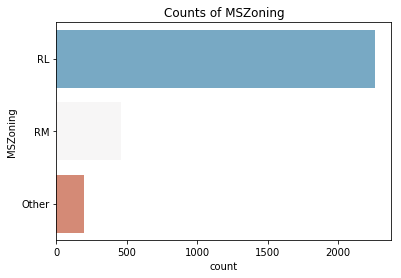

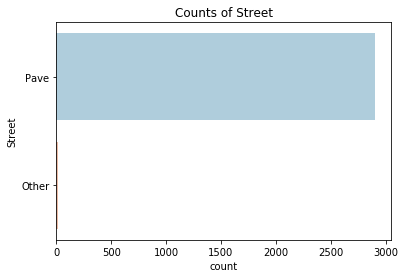

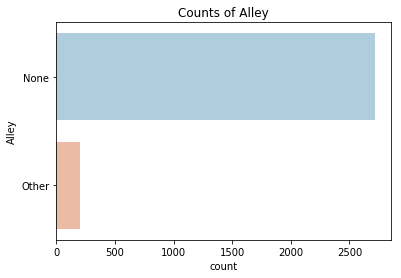

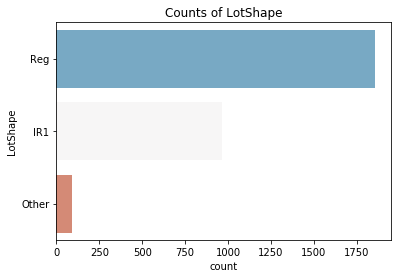

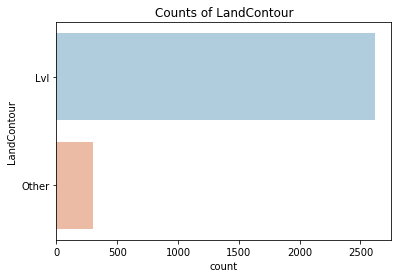

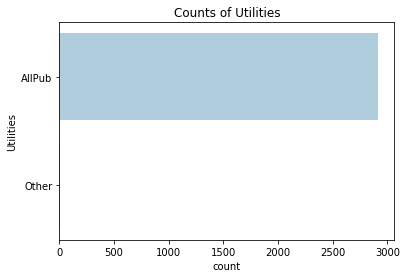

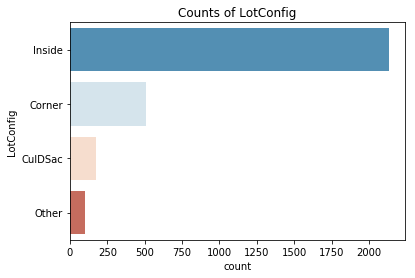

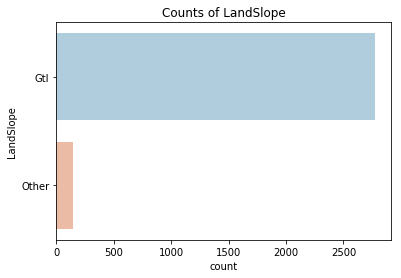

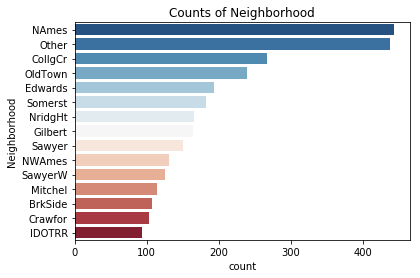

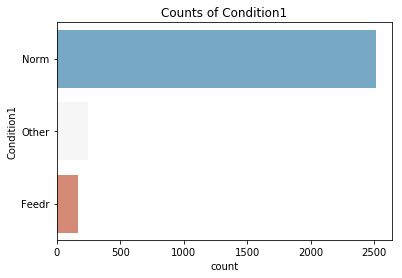

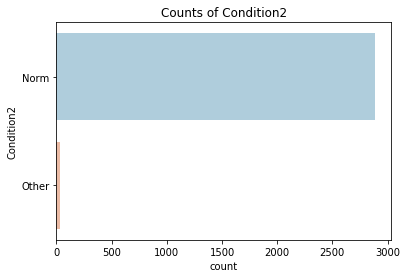

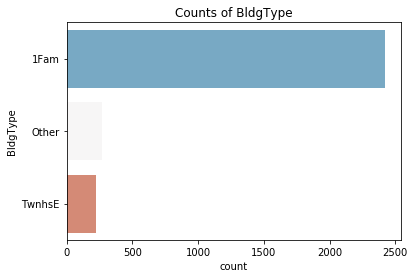

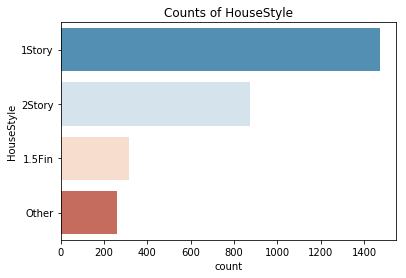

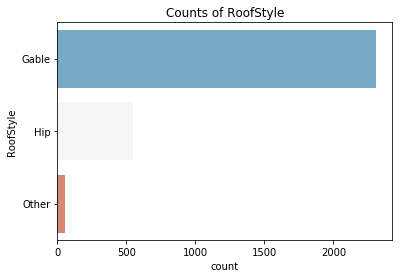

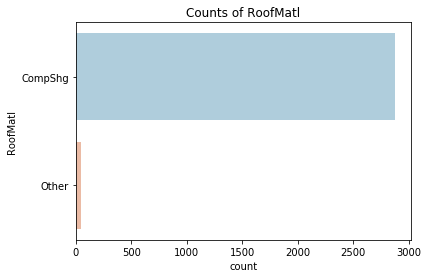

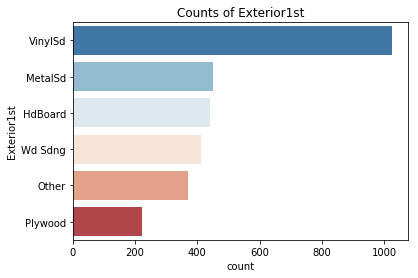

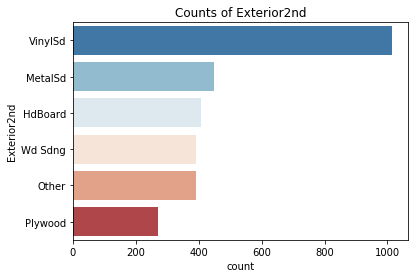

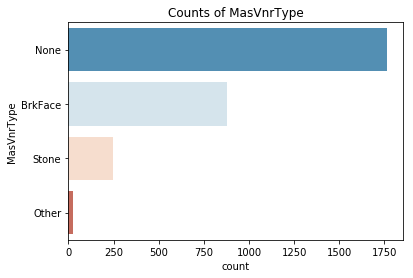

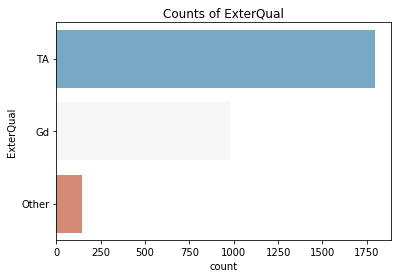

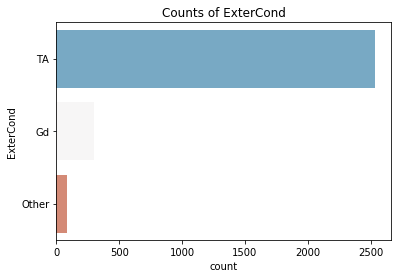

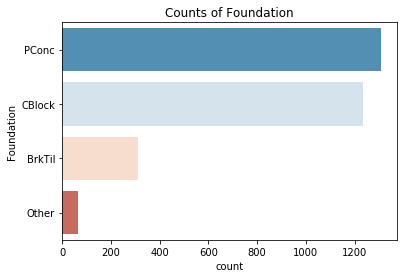

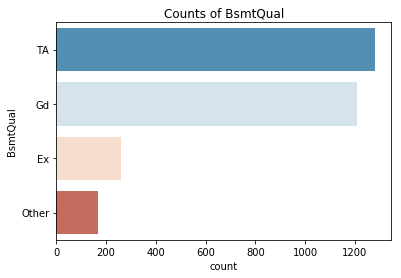

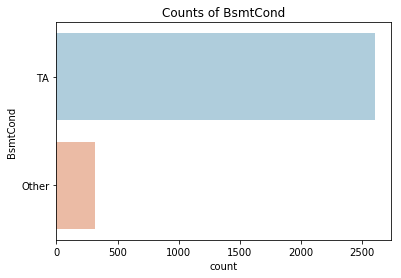

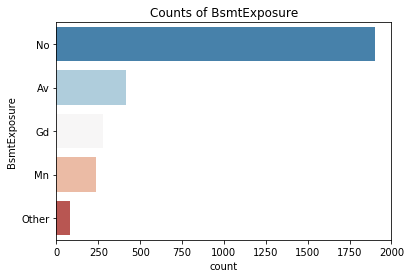

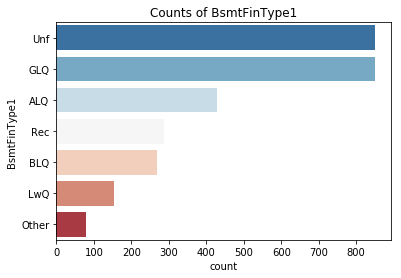

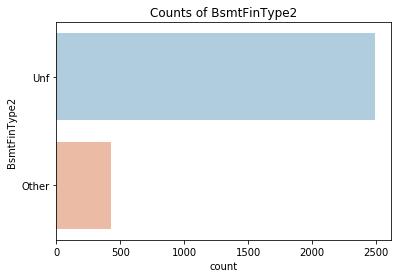

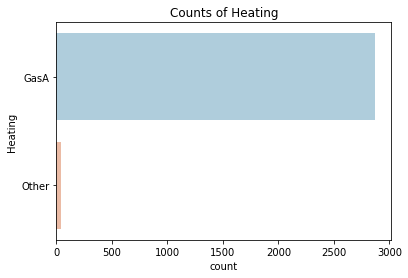

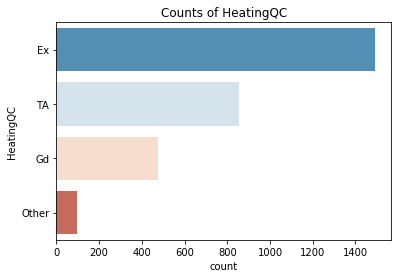

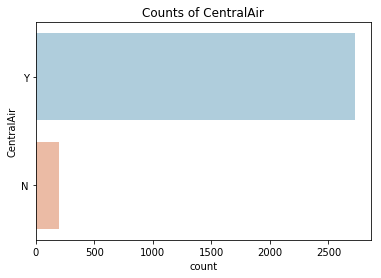

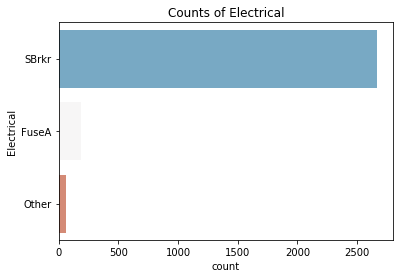

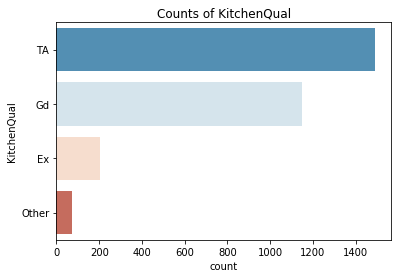

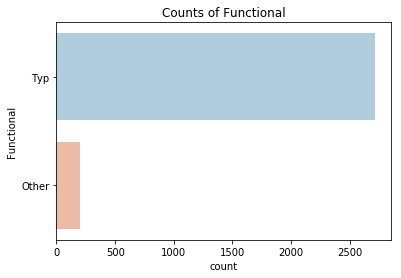

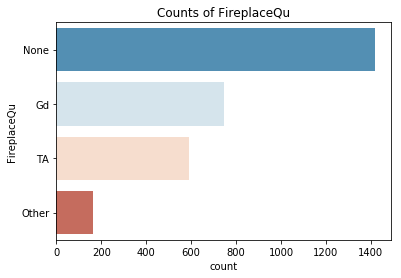

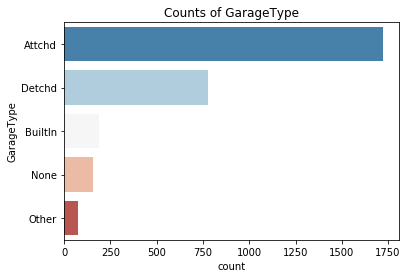

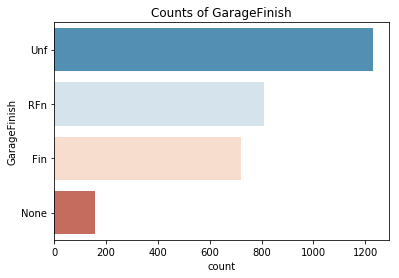

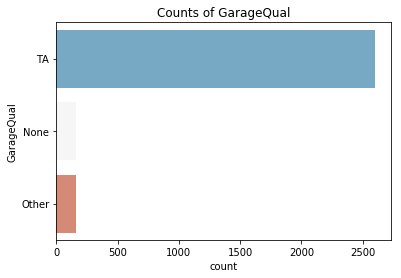

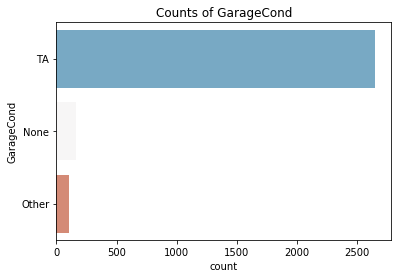

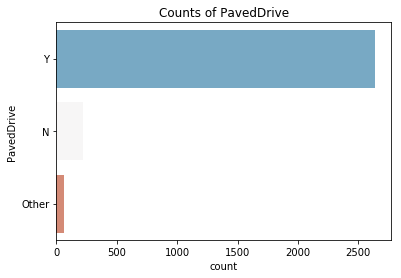

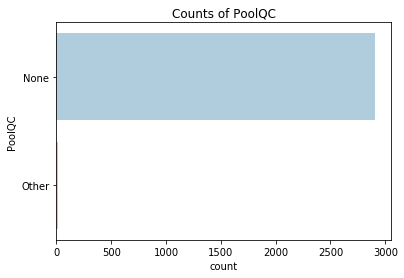

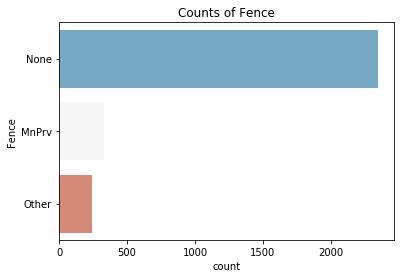

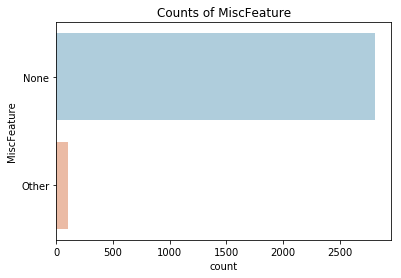

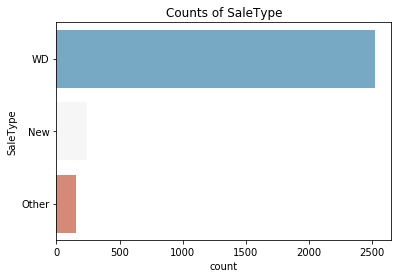

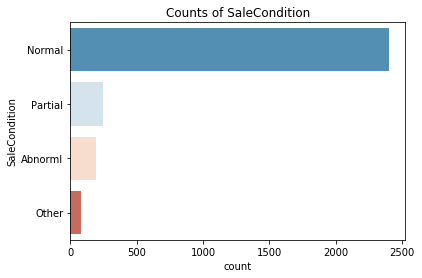

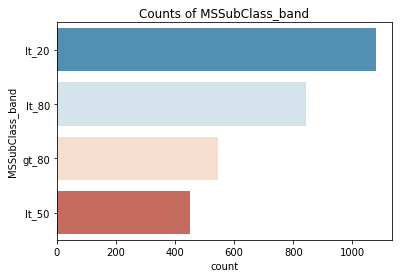

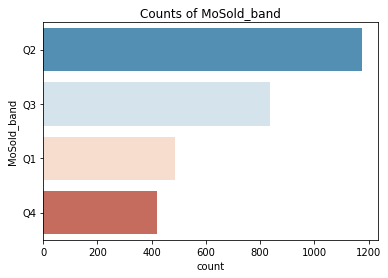

In [6]:
for i in range(0, len(CategoricalList)):
    countplotshorizontal(frame = df_all, field = CategoricalList[i], title = "Counts of " + CategoricalList[i], ylabel = CategoricalList[i], palette = "RdBu_r")

### Remove Skewed Categories
* Some Categories are Skewed so Let's Make a List of Those Where the Largest Group is >= 95%
* Remove These Values From the Categorical List

In [7]:
Temp = df_all[CategoricalList[0]].value_counts() / len(df_all)
df_Temp = pd.DataFrame(Temp)
df_Temp.reset_index(level = 0, inplace = True)
df_Temp['measure'] = CategoricalList[0]
df_Temp = df_Temp.rename(index = str, columns = {CategoricalList[0]: 'percent', 'index': 'category'})

for i in range(1, len(CategoricalList)):
    Temp = df_all[CategoricalList[i]].value_counts() / len(df_all)
    df_Temp1 = pd.DataFrame(Temp)
    df_Temp1.reset_index(level = 0, inplace = True)
    df_Temp1['measure'] = CategoricalList[i]
    df_Temp1 = df_Temp1.rename(index = str, columns = {CategoricalList[i]: 'percent', 'index': 'category'})
    df_Temp = pd.concat([df_Temp, df_Temp1])

df_Temp = df_Temp[df_Temp['percent'] >= 0.95]

SkewList = df_Temp['measure'].tolist()

print(bold + 'Categorical List \n' + reset, CategoricalList, '\n')
print(bold + 'Skew List \n' + reset, SkewList, '\n')

for i in range(0, len(SkewList)):
    CategoricalList.remove(SkewList[i])
    
print(bold + 'New Categorical List \n' + reset, CategoricalList)

Categorical List 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass_band', 'MoSold_band'] 

Skew List 
 ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC', 'MiscFeature'] 

New Categorical List 
 ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'B

In [8]:
idList = ['Id','segment']

TotalList = idList + ContinuousList + CategoricalList
df_all = df_all[TotalList].copy(deep = True)

display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition,MSSubClass_band,MoSold_band
0,1461,test,80,11622,5,6,0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1,730.0,140,0,0,0,120,0,0,0,49.0,49.0,49.0,0.0,1778,Other,None,Reg,Lvl,Inside,NAmes,Feedr,1Fam,1Story,Gable,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,Other,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,MnPrv,WD,Normal,lt_20,Q2
1,1462,test,81,14267,6,6,108,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1,312.0,393,36,0,0,0,0,12500,0,52.0,52.0,52.0,0.0,2658,RL,None,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,Hip,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,WD,Normal,lt_20,Q2
2,1463,test,74,13830,5,5,0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2,482.0,212,34,0,0,0,0,0,0,13.0,12.0,13.0,0.0,2557,RL,None,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,MnPrv,WD,Normal,lt_80,Q1
3,1464,test,78,9978,6,6,20,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2,470.0,360,36,0,0,0,0,0,0,12.0,12.0,12.0,0.0,2530,RL,None,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,WD,Normal,lt_80,Q2
4,1465,test,43,5005,8,5,0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2,506.0,0,82,0,0,144,0,0,0,18.0,18.0,18.0,0.0,2560,RL,None,IR1,Other,Inside,Other,Norm,TwnhsE,1Story,Gable,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,WD,Normal,gt_80,Q1


### One Hot Encode the Categorical Variables
* Performing XGBoost Requires the Categorical Variables to be One Hot Encoded

In [9]:
for i in range(0, len(CategoricalList)):
    df_all = pd.concat([df_all.drop(CategoricalList[i], axis=1), pd.get_dummies(df_all[CategoricalList[i]], prefix = CategoricalList[i])], axis=1)
    
display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
0,1461,test,80,11622,5,6,0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1,730.0,140,0,0,0,120,0,0,0,49.0,49.0,49.0,0.0,1778,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,1462,test,81,14267,6,6,108,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1,312.0,393,36,0,0,0,0,12500,0,52.0,52.0,52.0,0.0,2658,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
2,1463,test,74,13830,5,5,0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2,482.0,212,34,0,0,0,0,0,0,13.0,12.0,13.0,0.0,2557,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0

C:\Users\Armand\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


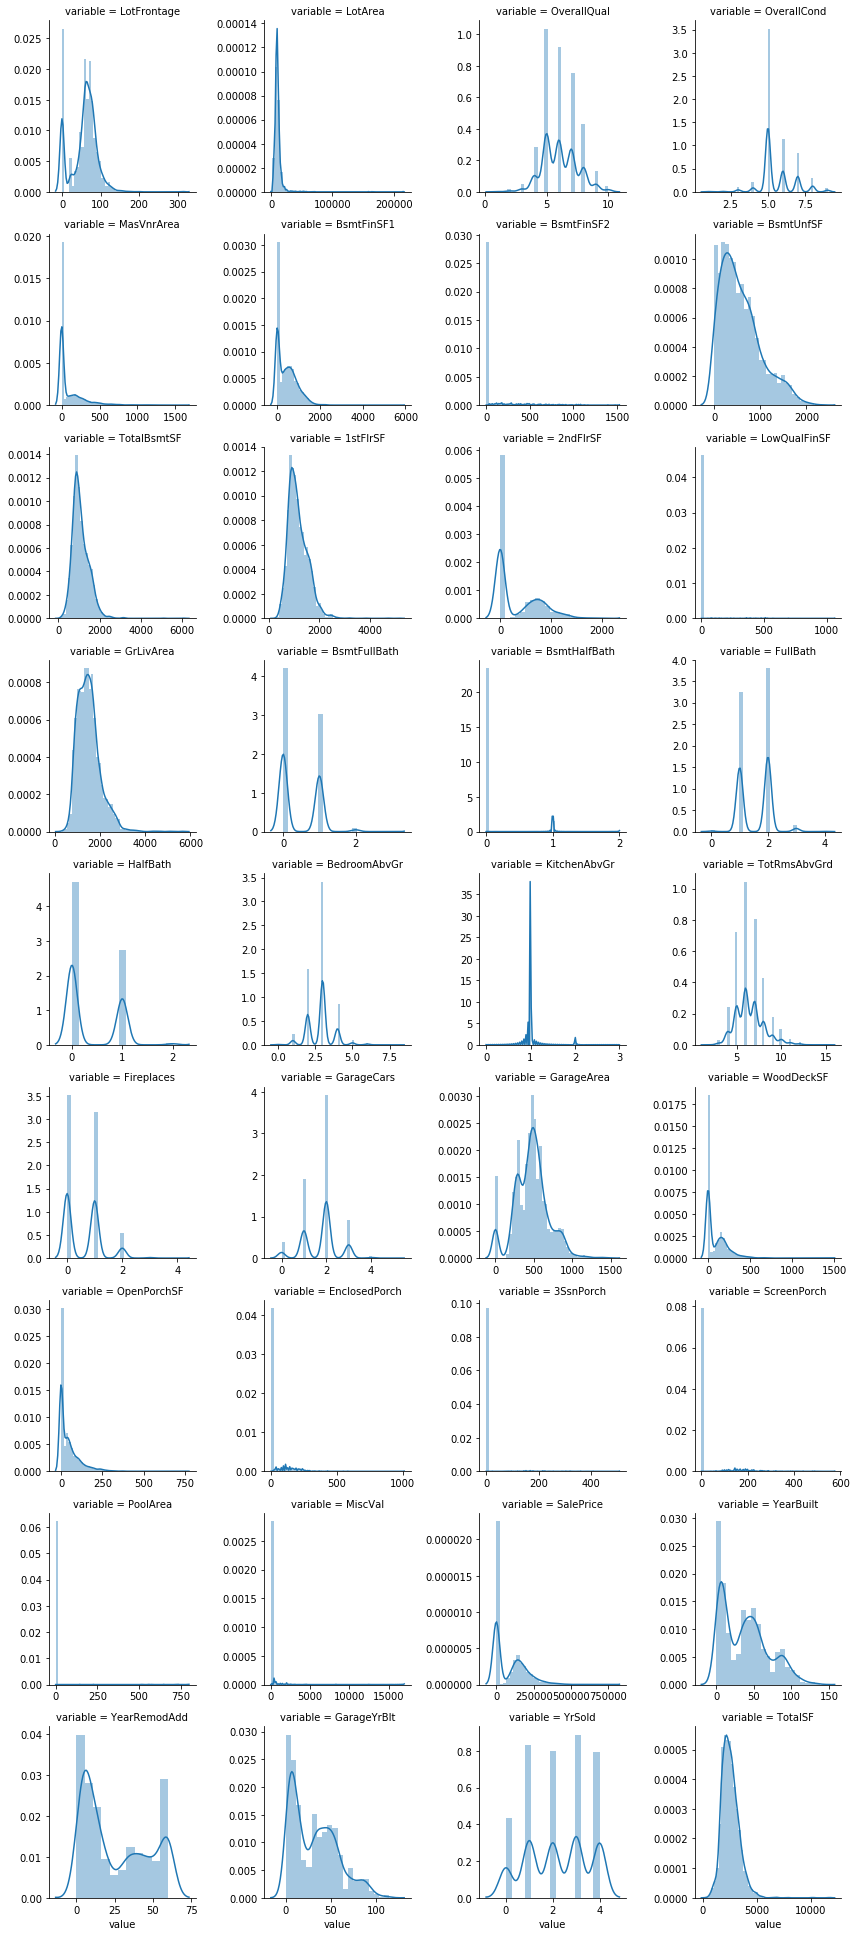

In [10]:
f = pd.melt(df_all, value_vars = ContinuousList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 4, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

In [11]:
### Continuous Variable Summary Statistics

pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df_all.filter(ContinuousList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF
count,"2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,840.00","2,840.00","2,840.00","2,840.00","2,919.00","2,919.00","2,919.00","2,919.00","2,840.00","2,840.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,760.00","2,919.00","2,919.00"
mean,57.77,"10,168.11",6.09,5.56,101.40,453.55,50.94,576.17,"1,080.66","1,159.58",336.48,4.69,"1,500.76",0.44,0.06,1.57,0.38,2.86,1.04,6.45,0.60,1.77,472.71,93.71,47.49,23.10,2.60,16.06,2.25,50.83,"90,491.59",38.69,25.74,31.96,2.21,"2,547.48"
std,33.48,"7,887.00",1.41,1.11,178.85,455.83,171.31,435.46,410.35,392.36,428.70,46.40,506.05,0.53,0.25,0.55,0.50,0.82,0.21,1.57,0.65,0.76,215.54,126.53,67.58,64.24,25.19,56.18,35.66,567.40,"106,496.38",30.29,20.89,25.21,1.31,805.12
min,0.00,"1,300.00",1.00,1.00,0.00,0.00,0.00,0.00,105.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,334.00
1%,0.00,"1,680.00",3.00,3.00,0.00,0.00,0.00,0.00,384.00,520.00,0.00,0.00,675.42,0.00,0.00,1.00,0.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,1.00,0.00,"1,014.18"
5%,0.00,"3,182.00",4.00,4.00,0.00,0.00,0.00,0.00,546.00,665.90,0.00,0.00,861.00,0.00,0.00,1.00,0.00,2.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,3.00,3.00,0.00,"1,511.80"
10%,0.00,"4,922.40",5.00,5.00,0.00,0.00,0.00,95.00,650.90,744.80,0.00,0.00,923.80,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,240.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,3.80,4.00,0.00,"1,696.00"
25%,43.00,"7,478.00",5.00,5.00,0.00,0.00,0.00,240.00,811.75,876.00,0.00,0.00,"1,126.00",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,320.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,6.00,8.00,1.00,"2,000.00"
50%,63.00,"9,453.00",6.00,5.00,0.00,384.00,0.00,482.50,"1,004.00","1,082.00",0.00,0.00,"1,444.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,2.00,480.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,"34,900.00",37.00,17.00,31.00,2.00,"2,448.00"
75%,78.00,"11,570.00",7.00,6.00,163.50,741.25,0.00,815.00,"1,313.00","1,387.50",704.00,0.00,"1,743.50",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2.00,576.00,168.00,70.00,0.00,0.00,0.00,0.00,0.00,"163,000.00",56.50,45.00,50.00,3.00,"2,991.50"


### Check Continuous for Skewness and Transform
* Anywhere Significant Skew is Found, Perform a Variable Transformation Using Box Cox or Log
* Threshold for the Initial Model was Chosen as 1.00.  However, Tighter Limits can be Chosen.

In [12]:
# Check the skew of all numerical features

ContinuousList.remove('SalePrice')

skewed_feats = df_all[ContinuousList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 1.00]
# skewness = skewness[abs(skewness) > 0.75]
skewness = skewness.dropna(how = 'all')
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print(skewness)

skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    df_all[feat] = boxcox1p(df_all[feat], lam)
    
ContinuousList.extend(['SalePrice'])

There are 18 skewed numerical features to Box Cox transform
               Skew
MiscVal       21.95
PoolArea      16.90
LotArea       12.82
LowQualFinSF  12.09
3SsnPorch     11.38
KitchenAbvGr   4.30
BsmtFinSF2     4.08
EnclosedPorch  4.00
ScreenPorch    3.95
BsmtHalfBath   3.87
MasVnrArea     2.61
OpenPorchSF    2.54
WoodDeckSF     1.84
TotalBsmtSF    1.73
TotalSF        1.51
1stFlrSF       1.47
BsmtFinSF1     1.41
GrLivArea      1.27


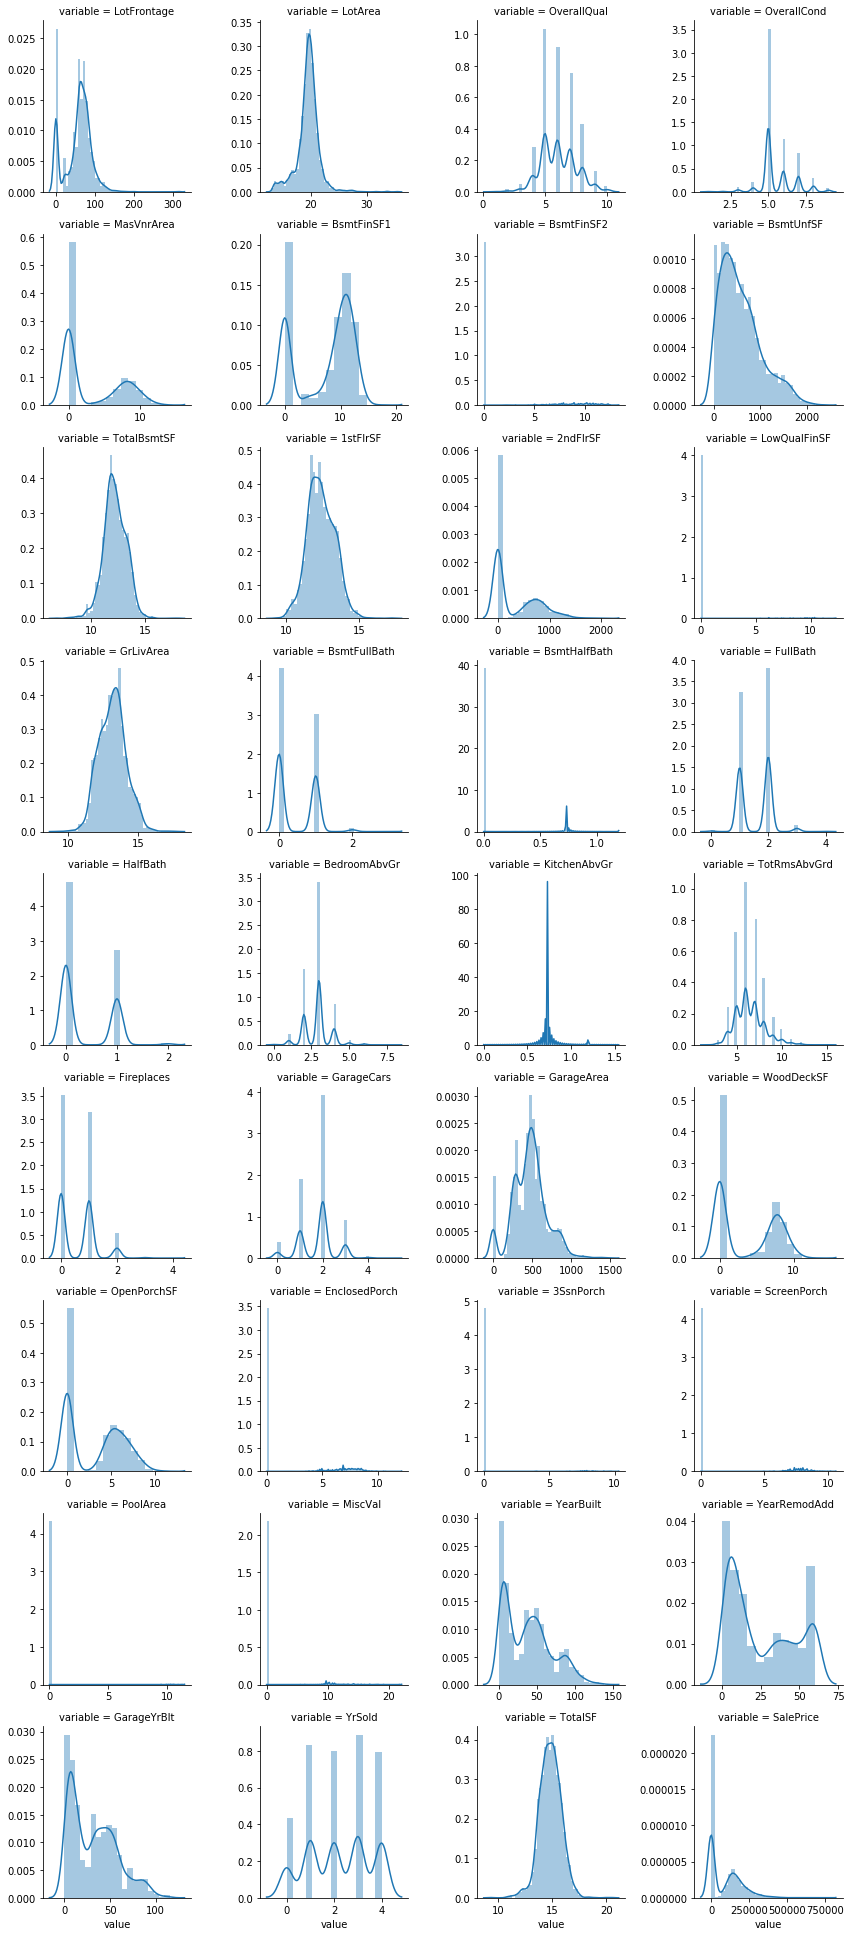

In [13]:
f = pd.melt(df_all, value_vars = ContinuousList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 4, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

In [14]:
### Continuous Variable Summary Statistics

pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df_all.filter(ContinuousList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

# display(HTML(df_train.filter(['SalePrice'], axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))
# display(HTML(df_test.filter(['SalePrice'], axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,SalePrice
count,"2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,840.00","2,840.00","2,840.00","2,840.00","2,919.00","2,919.00","2,919.00","2,919.00","2,840.00","2,840.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,760.00","2,919.00","2,919.00","2,919.00"
mean,57.77,19.49,6.09,5.56,3.21,7.26,1.12,576.17,12.18,12.42,336.48,0.12,13.17,0.44,0.05,1.57,0.38,2.86,0.75,6.45,0.60,1.77,472.71,3.71,3.29,1.12,0.10,0.68,0.05,0.41,38.69,25.74,31.96,2.21,14.82,"90,491.59"
std,33.48,1.98,1.41,1.11,4.12,5.06,3.09,435.46,1.05,0.93,428.70,1.05,0.97,0.53,0.18,0.55,0.50,0.82,0.10,1.57,0.65,0.76,215.54,3.98,3.11,2.64,0.90,2.21,0.68,2.20,30.29,20.89,25.21,1.31,1.00,"106,496.38"
min,0.00,12.88,1.00,1.00,0.00,0.00,0.00,0.00,6.75,9.28,0.00,0.00,9.28,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.28,0.00
1%,0.00,13.64,3.00,3.00,0.00,0.00,0.00,0.00,9.62,10.37,0.00,0.00,11.05,0.00,0.00,1.00,0.00,1.00,0.73,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,1.00,0.00,12.17,0.00
5%,0.00,15.69,4.00,4.00,0.00,0.00,0.00,0.00,10.50,11.01,0.00,0.00,11.71,0.00,0.00,1.00,0.00,2.00,0.73,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,3.00,3.00,0.00,13.33,0.00
10%,0.00,17.20,5.00,5.00,0.00,0.00,0.00,95.00,10.95,11.31,0.00,0.00,11.90,0.00,0.00,1.00,0.00,2.00,0.73,5.00,0.00,1.00,240.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,3.80,4.00,0.00,13.67,0.00
25%,43.00,18.74,5.00,5.00,0.00,0.00,0.00,240.00,11.55,11.76,0.00,0.00,12.46,0.00,0.00,1.00,0.00,2.00,0.73,5.00,0.00,1.00,320.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,6.00,8.00,1.00,14.18,0.00
50%,63.00,19.65,6.00,5.00,0.00,9.62,0.00,482.50,12.14,12.35,0.00,0.00,13.19,0.00,0.00,2.00,0.00,3.00,0.73,6.00,1.00,2.00,480.00,0.00,4.26,0.00,0.00,0.00,0.00,0.00,37.00,17.00,31.00,2.00,14.82,"34,900.00"
75%,78.00,20.46,7.00,6.00,7.67,11.30,0.00,815.00,12.91,13.07,704.00,0.00,13.76,1.00,0.00,2.00,1.00,3.00,0.73,7.00,1.00,2.00,576.00,7.72,5.97,0.00,0.00,0.00,0.00,0.00,56.50,45.00,50.00,3.00,15.48,"163,000.00"


### New We Assess the Target Variable for Transformation

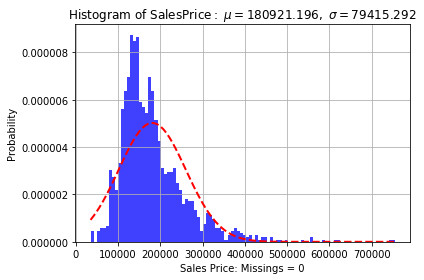

In [15]:
histogram(df_train['SalePrice'], 'Sales Price', 'blue', 100)

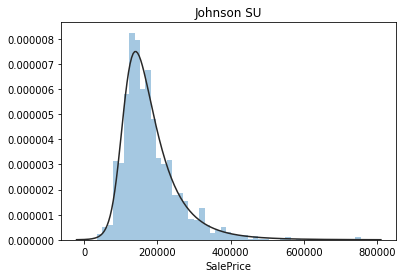

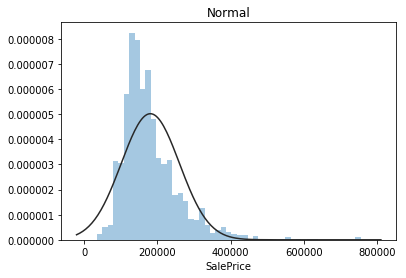

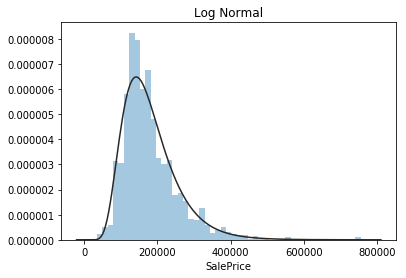

In [16]:
y = df_train['SalePrice']

plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde = False, fit = st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde = False, fit = st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde = False, fit = st.lognorm)

### Log Transform the Target Variable to Get Normal Distrubtion for Enhancing Accuracy of Linear Model


 mu = 180921.20 and sigma = 79415.29



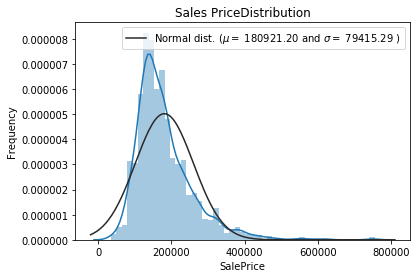

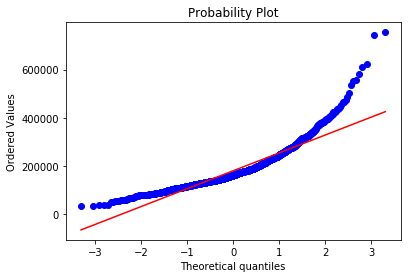

In [17]:
df_train = df_all[df_all['segment'] == 'train']
df_test = df_all[df_all['segment'] == 'test']

QQ(frame = df_train, variable = 'SalePrice', title = 'Sales Price')


 mu = 120240.51 and sigma = 3993.15



C:\Users\Armand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


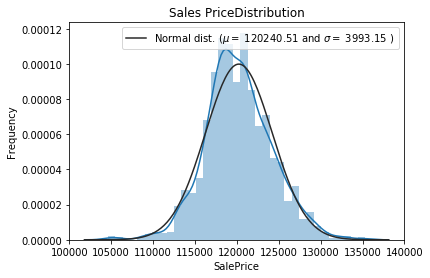

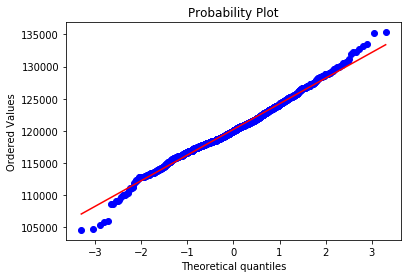

In [18]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice']) * 10000

QQ(frame = df_train, variable = 'SalePrice', title = 'Sales Price')

In [19]:
## Check to See if Taking Exponential Function of Log of Sales Price Reverts Back to Original Form

# df_train['SalePrice'] = np.exp(df_train['SalePrice'] / 10000)
# QQ(frame = df_train, variable = 'SalePrice', title = 'Sales Price')

In [20]:
df_all = pd.concat([df_train, df_test])
display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
1459,1,train,65,19.21,7,5,8.06,11.17,0.00,150.00,11.69,11.69,854,0.00,13.70,1.00,0.00,2,1,3,0.73,8,0,2,548.00,0.00,5.71,0.00,0.00,0.00,0.00,0.00,"122,476.94",7.00,7.00,7.00,2.00,14.98,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1460,2,train,80,19.71,6,8,0.00,12.06,0.00,284.00,12.79,12.79,0,0.00,12.79,0.00,0.73,2,0,3,0.73,6,1,2,460.00,9.01,0.00,0.00,0.00,0.00,0.00,0.00,"121,090.11",34.00,34.00,34.00,3.00,14.92,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1461,3,train,68,20.35,7,5,7.65,10.20,0.00,434.00,11.89,11.89,866,0.00,13.83,1.00,0.00,2,1,3,0.73,6,1,2,608.00,0.00,5.05,0.00,0.00,0.00,0.00,0.00,"123,171.67",9.00,8.00,9.00,2.00,15.15,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1

### Missing Values
* Count Missing Values. Most of These were Eliminated During Feature Engineering. 
* However, Missing Values Need to be Converted to Integers so they can be Put into an Array for XGBoost.
* We'll Convert Missings to -99 and Tell XGBoost to Treat -99s as Missing.

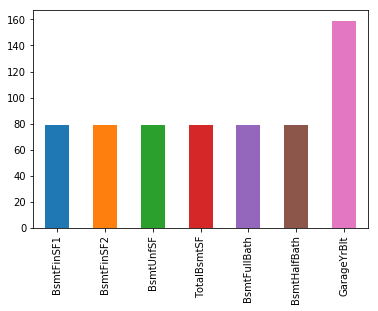

In [21]:
missing = df_all.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

MissingList = missing.index.tolist()

for i in range(0, len(MissingList)):
    df_all[MissingList[i]] = df_all[MissingList[i]].replace(np.nan, -99).astype(np.int64)

In [22]:
# Save DataFrames

os.chdir(sys.path[0] + '\\Data')

# Convert These Lists to Dataframes Since it's Not Possible to Pickle Lists

df_categorical = pd.DataFrame(CategoricalList, columns = ['column'])
df_continuous = pd.DataFrame(ContinuousList, columns = ['column'])

df_all.to_pickle('df_all_2.pkl')

df_categorical.to_pickle('df_categorical_2.pkl')
df_continuous.to_pickle('df_continuous_2.pkl')

In [23]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

18.81367540359497 seconds
0.31356125672658286 minutes
0.005226020945443047 hours
